In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import math
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [50]:
#Function to convert GPS time to milliseconds
#The base time is the RTC time in milliseconds that corresponds with the first GPS time stamp
def timeToMillis(time, RTC_millis):
    sec = np.zeros(time.size)
    sec = sec.astype(int)
    minutes = np.zeros(time.size)
    minutes = minutes.astype(int)
    hours = np.zeros(time.size)
    hours = hours.astype(int)
    for i in range(0, time.size):
        sec[i] = time[i]%100
    for i in range(0, time.size):
        minutes[i] = (time[i]%10000 - time[i]%100)/100
    for i in range(0, time.size):
        hours[i] = (time[i] - time[i]%10000)/10000

    GPS_millis = np.zeros(time.size)
    GPS_millis = GPS_millis.astype(int)
    GPS_millis[0] = RTC_millis[0]
    for i in range (1, time.size):
        if (sec[i] > sec[i - 1]):
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1])*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (60 + minutes[i] - minutes[i - 1])*60*1000            
        else:
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1] - 1)*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (59 + minutes[i] - minutes[i - 1])*60*1000            
    return GPS_millis


#Function to convert time in milliseconds to digital time 
#Used to convert both GPS time in milliseconds and RTC time in milliseconds to digital time 
#The base time is taken as the first GPS time stamp
def millisToTime(millis, time):
    mil = millis/1000
    time_temp = np.zeros(time.size)
    hours = np.zeros(time_temp.size)
    minutes = np.zeros(time_temp.size)
    seconds = np.zeros(time_temp.size)
    time_temp[0] = time[0]
    for i in range (1, time.size):
        seconds[i] = time_temp[i - 1]%100 + (mil[i] - mil[i - 1])
        if (seconds[i] > 60):
            temp_minutes = 0
            while (seconds[i] >= 60):
                temp_minutes += 100
                seconds[i] = seconds[i] - 60
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + temp_minutes
        elif (seconds[i] == 60):
            seconds[i] = 0
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + 100
        else:
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100)
        if (minutes[i] > 5900):
            minutes[i] = 6000 - minutes[i]
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000) + 10000
        else:
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000)
        if (hours[i] > 230000):
            hours[i] = 240000 - hours[i]
        time_temp[i] = hours[i] + minutes[i] + seconds[i]

    #Split time with colons
    output_time = [0 for i in range(time_temp.size)]
    hours_temp = np.zeros(time_temp.size)
    minutes_temp = np.zeros(time_temp.size)
    seconds_temp = np.zeros(time_temp.size)
    for i in range (0, time_temp.size):
        hours_temp[i] = int((time_temp[i] - time_temp[i]%10000)/10000)
        minutes_temp[i] = int((time_temp[i]%10000 - time_temp[i]%100)/100)
        seconds_temp[i] = time_temp[i]%100
        if (seconds_temp[i] < 10):
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
            else:
                output_time[i] = "%d:%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
        else:
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])  
            else:
                output_time[i] = "%d:%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
    return output_time 

#Split data into training and testing sets (0.8/0.2)
def dataSplit(x_millis, y_millis):
    x_train, x_test, y_train, y_test = train_test_split(x_millis, y_millis, test_size=0.2, random_state=1)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 1)
    return x_train.reshape(-1,1), y_train.reshape(-1,1), x_test.reshape(-1,1), y_test.reshape(-1,1), x_val.reshape(-1,1), y_val.reshape(-1,1)


#Metrics for regression analysis
def RMSE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = (y[i] - predict[i])**2
    return np.sqrt((np.sum(c))/len(c))

def MAE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = abs(y[i] - predict[i])
    return (np.sum(c))/len(c)

#Metrics related to clock AccOffset 
def plotDrift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    t = np.linspace(10000, len(GPS_millis), len(GPS_millis[10000:len(GPS_millis)]))
    plt.plot(t, Drift[10000:len(GPS_millis)])
    plt.title('Frequency of clock drift of Teensy internal RTC (ppm)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Drift (ppm)')
    plt.show()

def plotOffset(GPS_millis, RTC_millis):
    offset = np.zeros(GPS_millis.size)
    offsetsum = 0
    for i in range(0, GPS_millis.size):
        offset[i] = (GPS_millis[i] - offsetsum - RTC_millis[i])
        offsetsum = np.sum(offset)
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, offset)
    plt.title('Clock offset of internal Teensy RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Clock offset (ms)')
    plt.show()
    

def plotAccOffset(GPS_millis, RTC_millis):
    AccOffset = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        AccOffset[i] = (GPS_millis[i] - RTC_millis[i])
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, AccOffset)
    plt.title('Accumulated offset of Teensy internal RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Accumulated offset (ms)')
    plt.show()
    
def AccOffset(GPS_millis, RTC_millis):
    d = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        d[i] = (GPS_millis[i] - RTC_millis[i])
    return d

def Drift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    return Drift

def convertToCycles(array):
    a = np.zeros(array.size)
    for i in range(0, array.size):
        a[i] = (array[i]/1000)*32768
    return a

#dataframe to summarise linear regression metrics
def RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, model):
    predict1 = model.predict(x1_train)
    r1 =  model.score(x1_train, y1_train)
    rmse1 = RMSE(predict1, y1_train)
    mae1 =  MAE(predict1, y1_train)
    
    predict2 = model.predict(x1_test)
    r2 = model.score(x1_test, y1_test)
    rmse2 = RMSE(predict2, y1_test)
    mae2 = MAE(predict2, y1_test)
    
    predict3 = model.predict(x1_val)
    r3 = model.score(x1_val, y1_val)
    rmse3 = RMSE(predict3, y1_val)
    mae3 = MAE(predict3, y1_val)
    
    d = {'Index Title': ['Training', 'Validation', 'Test'],'R': [r1, r3, r2], 'RMSE' : [rmse1, rmse3, rmse2], 'MAE' :[mae1, mae3, mae2]}
    df = pd.DataFrame(d).set_index('Index Title')
    return display(df)


#Data Frames to summarise metrics for testing sets and display synchronised time
def synch(RTC_millis, GPS_millis, model, time, AccOffset):
    millis_predict = model.predict(RTC_millis.reshape(-1, 1))
    #Convert AccOffset prediction to synchronised time by adding the AccOffset to RTC time in milliseconds
    for i in range (0, millis_predict.size):
        millis_predict[i] = RTC_millis[i] + millis_predict[i]
    millis_predict = (np.reshape(millis_predict, len(millis_predict))).astype(int)
    r =  model.score(RTC_millis.reshape(-1, 1), AccOffset.reshape(-1, 1))
    rmse =  RMSE(millis_predict, GPS_millis)
    mae = MAE(millis_predict, GPS_millis)
    
    d = {'R': [r], 'RMSE' : [rmse], 'MAE' :[mae]}
    d = pd.DataFrame(d)
    display(d)
    df = pd.DataFrame({'GPS Time (ms)': GPS_millis, 'RTC Time (ms)': RTC_millis, 
                         'Synch Time (ms)' : millis_predict, 'GPS Time': millisToTime(GPS_millis, time),
                           'RTC Time':millisToTime(RTC_millis, time), 'Synch Time' : millisToTime(millis_predict, time)})
    return display(df)

In [51]:
#Reading data from training run of sensor 1
with open('GPT2.TXT', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open('GPT2.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('GPS/RTC', 'Time', 'Day', 'Month', 'Year', 'Millis', 'Temp', 'Offset', 'Number'))
        writer.writerows(lines)
        
data1 = pd.read_csv("GPT2.csv")
data_arr1 = np.array(data1)
time1 = data_arr1[0:,1]
#RTC_millis1 = data_arr1[0:,5]
temp1 = data_arr1[0:,6]
offset1 = data_arr1[0:,7]
num1 = data_arr1[0:,8]

#Cleaning data
#for i in range(0, 131063):
#    RTC_millis1[i] = (RTC_millis1[i]- 9*(32768) - 12343)/32768
#RTC_millis1[131063] = 32768  
#for i in range(131064, RTC_millis1.size):
#    RTC_millis1[i] = RTC_millis1[i] + 6662
#for i in range(131063, RTC_millis1.size):
#    RTC_millis1[i] = RTC_millis1[i]/32768 + RTC_millis1[131062]
#cycles = np.zeros(RTC_millis1.size)
#for i in range(RTC_millis1.size):
#    cycles[i] = RTC_millis1[i]*32768
#for i in range(RTC_millis1.size):
#    RTC_millis1[i] = RTC_millis1[i]*1000

RTC_millis1 = np.zeros(offset1.size)
for i in range(0, offset1.size):
    RTC_millis1[i] = offset1[i] + RTC_millis1[i - 1]
for i in range(0, offset1.size):
    RTC_millis1[i] = (RTC_millis1[i]/32768)*1000

In [52]:
#Determining the GPS milliseconds since start-up for all three sensors
GPS_millis1 = timeToMillis(time1, RTC_millis1)

#Determining the AccOffset of all three sensors
AccOffset1 = AccOffset(GPS_millis1, RTC_millis1)

#Splitting the training and testing data only for the first sensor (on which the model is built and tested)
x1_train, y1_train, x1_test, y1_test, x1_val, y1_val = dataSplit(RTC_millis1, AccOffset1)

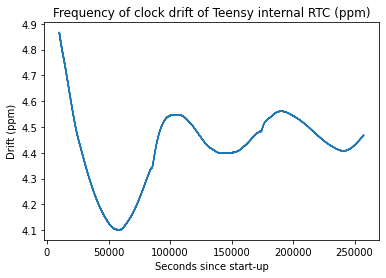

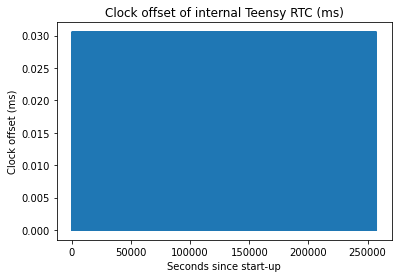

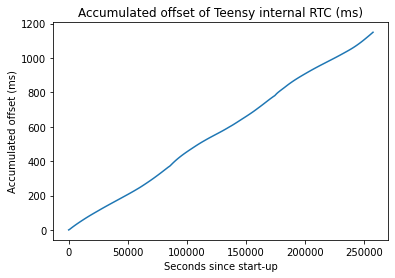

In [53]:
#Drift and AccOffset graphs of all three sensor sets
plotDrift(GPS_millis1, RTC_millis1)
plotOffset(GPS_millis1, RTC_millis1)
plotAccOffset(GPS_millis1, RTC_millis1)


In [28]:
print('RMSE Testing Sensor One: ', RMSE(RTC_millis1, GPS_millis1))
print('MAE Testing Sensor One:', MAE(RTC_millis1, GPS_millis1))

RMSE Testing Sensor One:  662.5036063537375
MAE Testing Sensor One: 572.0138910892798


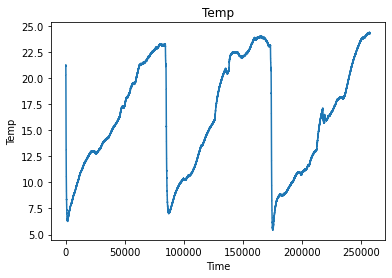

In [49]:
t = np.linspace(0, len(temp1), len(temp1))
plt.plot(t, temp1)
plt.title('Temp')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.show()

In [30]:
drift = Drift(GPS_millis1, RTC_millis1)
accOffset = AccOffset(GPS_millis1, RTC_millis1)

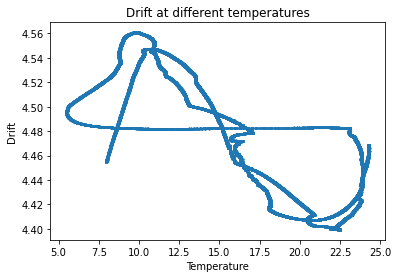

In [31]:
plt.scatter(temp1[90000:drift.size], drift[90000:drift.size], s = 2)
plt.title('Drift at different temperatures')
plt.xlabel('Temperature')
plt.ylabel('Drift')
plt.show()


In [33]:
print('Mean drift:', np.mean(drift))
print('Mean accumulated offset:', np.mean(accOffset))
print('Mean temperature:', np.mean(temp1))

Mean drift: 4.436217878974146
Mean accumulated offset: 572.0138910892798
Mean temperature: 16.185029182052705


In [34]:
# Linear Regression
model1 = LinearRegression().fit(x1_train, y1_train)
print("Performance of model on training set")
RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, model1)
print("Synchronised time: Training set Sensor 1")
synch(RTC_millis1, GPS_millis1, model1, time1, accOffset)
#synch.to_csv(r'C:\Users\suben\Documents\Priyanka\Skripsie\synch1.csv', index = False)

Performance of model on training set


,R,RMSE,MAE
Index Title,,,
Training,0.999043,10.335643,9.066946
Validation,0.999042,10.340819,9.085895
Test,0.999052,10.343520,9.073011


Synchronised time: Training set Sensor 1


,R,RMSE,MAE
0,0.999043,10.337229,9.049578


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,993,19:17:16.000,19:17:16.000,19:17:16.000
1,2000,2.000000e+03,1993,19:17:17.000,19:17:17.000,19:17:17.000
2,3000,3.000000e+03,2993,19:17:18.000,19:17:18.000,19:17:18.000
3,4000,4.000000e+03,3993,19:17:19.000,19:17:19.000,19:17:19.000
4,5000,5.000000e+03,4993,19:17:20.000,19:17:20.000,19:17:20.000
...,...,...,...,...,...,...
257345,257346000,2.573449e+08,257346000,18:46:21.000,18:46:19.850,18:46:21.007
257346,257347000,2.573459e+08,257347000,18:46:22.000,18:46:20.850,18:46:22.007
257347,257348000,2.573469e+08,257348000,18:46:23.000,18:46:21.850,18:46:23.007
257348,257349000,2.573479e+08,257349000,18:46:24.000,18:46:22.850,18:46:24.007


In [41]:
net1 = MLPRegressor(alpha = 1e-4, solver = 'adam', random_state =1,
                  learning_rate_init = 0.1/(10*3)).fit(x1_train, np.reshape(y1_train, len(y1_train)))
print("Performance of model on training set")
RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, net1)
print("Synchronised time: Training set Sensor 1")
synch(RTC_millis1, GPS_millis1, net1, time1, accOffset)

Performance of model on training set


,R,RMSE,MAE
Index Title,,,
Training,0.998916,10.996032,8.958015
Validation,0.998918,10.993960,8.976435
Test,0.998929,10.993009,8.947828


Synchronised time: Training set Sensor 1


,R,RMSE,MAE
0,0.998918,10.999262,8.958077


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,1000,19:17:16.000,19:17:16.000,19:17:16.000
1,2000,2.000000e+03,2000,19:17:17.000,19:17:17.000,19:17:17.000
2,3000,3.000000e+03,3000,19:17:18.000,19:17:18.000,19:17:18.000
3,4000,4.000000e+03,4000,19:17:19.000,19:17:19.000,19:17:19.000
4,5000,5.000000e+03,5000,19:17:20.000,19:17:20.000,19:17:20.000
...,...,...,...,...,...,...
257345,257346000,2.573449e+08,257345994,18:46:21.000,18:46:19.850,18:46:20.994
257346,257347000,2.573459e+08,257346994,18:46:22.000,18:46:20.850,18:46:21.994
257347,257348000,2.573469e+08,257347994,18:46:23.000,18:46:21.850,18:46:22.994
257348,257349000,2.573479e+08,257348994,18:46:24.000,18:46:22.850,18:46:23.994


In [36]:
error = np.zeros(20)
for i in range(1, 20):
    net1 = MLPRegressor(alpha = 1e-4, solver = 'adam', random_state =1,
                  learning_rate_init = 0.1/(10*i)).fit(x1_train, np.reshape(y1_train, len(y1_train)))
    predict = net1.predict(x1_val)
    error[i - 1] = RMSE(predict, y1_val)

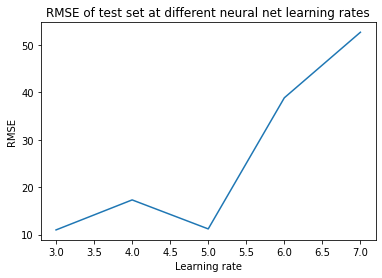

[5.91547135e+02 1.52126606e+01 1.09939603e+01 1.73286651e+01
 1.12056775e+01 3.88789794e+01 5.27168843e+01 2.14303150e+01
 7.02336770e+02 1.44292756e+03 1.58526371e+01 1.66894526e+01
 1.76667036e+05 2.59377175e+01 4.20038259e+01 1.35308027e+01
 1.12279079e+02 1.10275543e+01 1.95016180e+02 0.00000000e+00]


In [40]:
t = np.linspace(3, 7, 5)
plt.plot(t, error[2:7])
plt.title('RMSE of test set at different neural net learning rates')
plt.xlabel('Learning rate')
plt.ylabel('RMSE')
plt.show()
print(error)

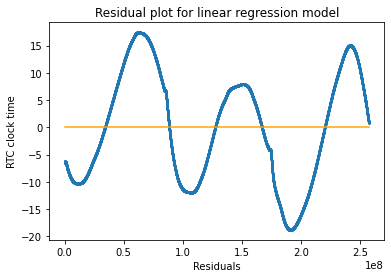

In [42]:
predict1 = model1.predict(x1_val)
resid1 = np.zeros(y1_val.size)
for i in range(y1_test.size):
    resid1[i] = predict1[i] - y1_val[i]
#Residual plots
t = np.linspace(0, max(x1_val))
z = np.zeros(50)
plt.scatter(x1_val, resid1, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for linear regression model')
plt.xlabel('Residuals')
plt.ylabel('RTC clock time')
plt.show()

In [43]:
#Polynomial regression
poly = PolynomialFeatures(9)

poly_train = poly.fit_transform(x1_train.reshape(-1,1))
poly_val = poly.fit_transform(x1_val.reshape(-1,1))
poly_test = poly.fit_transform(x1_test.reshape(-1,1))
poly_millis = poly.fit_transform(RTC_millis1.reshape(-1,1))

model2 = linear_model.Ridge(alpha=.5).fit(poly_train, y1_train)

print("Performance of model on training set")
RegMetrics(poly_train, y1_train, poly_val, y1_val, poly_test, y1_test, model2)

print("RMSE full set:", RMSE(model2.predict(poly_millis), AccOffset1))
print("MAE full set:", MAE(model2.predict(poly_millis), AccOffset1))

#print("Synchronised time: Training set Sensor 1")
#synch(poly_millis, GPS_millis1, model1, time1, accOffset)

C:\Users\suben\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33552e-156): result may not be accurate.
  overwrite_a=True).T


Performance of model on training set


,R,RMSE,MAE
Index Title,,,
Training,0.999962,2.057119,1.756029
Validation,0.999962,2.060727,1.759722
Test,0.999962,2.059392,1.758865


RMSE full set: 2.0577075801372504
MAE full set: 1.7566822351158156


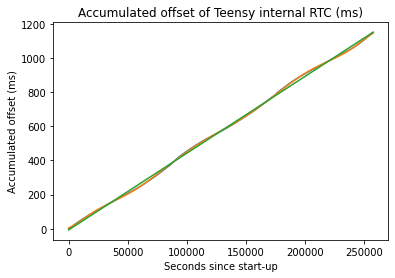

In [44]:
prediction = model2.predict(poly_millis)
prediction2 = model1.predict(RTC_millis1.reshape(-1,1))
AccOffset = np.zeros(GPS_millis1.size)
for i in range(0, GPS_millis1.size):
    AccOffset[i] = (GPS_millis1[i] - RTC_millis1[i])
t = np.linspace(0, len(GPS_millis1), len(GPS_millis1))
plt.plot(t, AccOffset)
plt.plot(t, prediction)
plt.plot(t, prediction2)
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.show()

In [45]:
print("Synchronised time: Training set Sensor 1")
millis_predict = model2.predict(poly_millis)
#Convert AccOffset prediction to synchronised time by adding the AccOffset to RTC time in milliseconds
for i in range (0, millis_predict.size):
    millis_predict[i] = RTC_millis1[i] + millis_predict[i]
millis_predict = (np.reshape(millis_predict, len(millis_predict))).astype(int)
r =  model2.score(poly_millis, AccOffset1.reshape(-1, 1))
rmse =  RMSE(millis_predict, GPS_millis1)
mae = MAE(millis_predict, GPS_millis1)
    
d = {'R': [r], 'RMSE' : [rmse], 'MAE' :[mae]}
d = pd.DataFrame(d)
display(d)
df = pd.DataFrame({'GPS Time (ms)': GPS_millis1, 'RTC Time (ms)': RTC_millis1, 
                     'Synch Time (ms)' : millis_predict, 'GPS Time': millisToTime(GPS_millis1, time1),
                        'RTC Time':millisToTime(RTC_millis1, time1), 'Synch Time' : millisToTime(millis_predict, time1)})

display(df)

Synchronised time: Training set Sensor 1


,R,RMSE,MAE
0,0.999962,2.123889,1.767161


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,1005,19:17:16.000,19:17:16.000,19:17:16.000
1,2000,2.000000e+03,2005,19:17:17.000,19:17:17.000,19:17:17.000
2,3000,3.000000e+03,3005,19:17:18.000,19:17:18.000,19:17:18.000
3,4000,4.000000e+03,4005,19:17:19.000,19:17:19.000,19:17:19.000
4,5000,5.000000e+03,5005,19:17:20.000,19:17:20.000,19:17:20.000
...,...,...,...,...,...,...
257345,257346000,2.573449e+08,257345994,18:46:21.000,18:46:19.850,18:46:20.989
257346,257347000,2.573459e+08,257346994,18:46:22.000,18:46:20.850,18:46:21.989
257347,257348000,2.573469e+08,257347994,18:46:23.000,18:46:21.850,18:46:22.989
257348,257349000,2.573479e+08,257348994,18:46:24.000,18:46:22.850,18:46:23.989


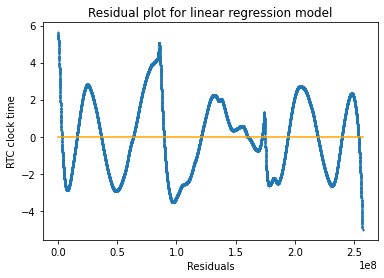

In [46]:
predict2 = model2.predict(poly_val)
resid2 = np.zeros(y1_val.size)
for i in range(y1_val.size):
    resid2[i] = predict2[i] - y1_val[i]
#Residual plots
t = np.linspace(0, max(x1_val))
z = np.zeros(50)
plt.scatter(x1_val, resid2, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for linear regression model')
plt.xlabel('Residuals')
plt.ylabel('RTC clock time')
plt.show()

In [383]:
#TensorFlow linear regression
normalizer1 = preprocessing.Normalization()
normalizer1.adapt(x1_train)

model3 = tf.keras.Sequential([
    normalizer1,
    layers.Dense(units=1)
])

model3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history1 = model3.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    epochs = 8,
    verbose = 1
    )

Train on 205880 samples
Epoch 1/8
205880/205880 [==============================] - 6s 31us/sample - loss: 260.4948
Epoch 2/8
205880/205880 [==============================] - 6s 29us/sample - loss: 8.9923
Epoch 3/8
205880/205880 [==============================] - 6s 30us/sample - loss: 8.9925
Epoch 4/8
205880/205880 [==============================] - 6s 29us/sample - loss: 8.9927
Epoch 5/8
205880/205880 [==============================] - 6s 30us/sample - loss: 8.99280s - loss: 8
Epoch 6/8
205880/205880 [==============================] - 6s 29us/sample - loss: 8.9940
Epoch 7/8
205880/205880 [==============================] - 6s 29us/sample - loss: 8.9930
Epoch 8/8
205880/205880 [==============================] - 6s 30us/sample - loss: 8.99270s - l


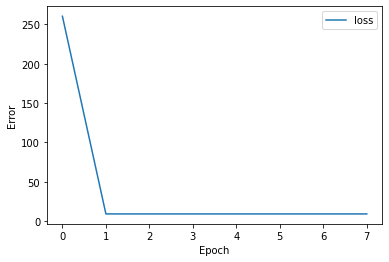

In [390]:
def plot_loss(history):
  plt.plot(history1.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
plot_loss(history1)

In [382]:
predict = model3.predict(np.reshape(x1_val, len(x1_val)).astype(float))
predict = np.reshape((predict),len(predict))
print(MAE(predict, y1_val))
print(RMSE(predict, y1_val))

9.010073019486851
10.747142183216972


In [356]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
#Convert Keras model to a tflite model 
converter1 = tf.lite.TFLiteConverter.from_keras_model(model3)
converter1.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model1 = converter1.convert()
open('GPT2Model' + '.tflite', 'wb').write(tflite_model1)

# Write TFLite model to a C source (or header) file
with open('GPT2Model' + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model1, 'GPT2Model'))

In [391]:
#Tensor flow neural network
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

net2 = build_and_compile_model(normalizer1)

history2 = net2.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    verbose=1, epochs=8)

Train on 205880 samples
Epoch 1/8
205880/205880 [==============================] - 7s 36us/sample - loss: 31.7790
Epoch 2/8
205880/205880 [==============================] - 7s 35us/sample - loss: 5.6656
Epoch 3/8
205880/205880 [==============================] - 7s 35us/sample - loss: 5.6570ETA: 0s 
Epoch 4/8
205880/205880 [==============================] - 7s 35us/sample - loss: 5.6518
Epoch 5/8
205880/205880 [==============================] - 7s 35us/sample - loss: 5.65251s - loss: 5.6 - ETA:
Epoch 6/8
205880/205880 [==============================] - 7s 36us/sample - loss: 5.6585
Epoch 7/8
205880/205880 [==============================] - 8s 38us/sample - loss: 5.6487
Epoch 8/8
205880/205880 [==============================] - 8s 39us/sample - loss: 5.6532


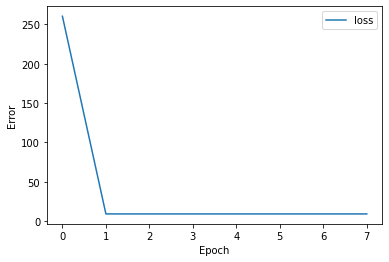

In [392]:
plot_loss(history2)

In [394]:
predict2 = net1.predict((x1_val).astype(float))
predict2 = np.reshape((predict),len(predict))
print(MAE(predict, y1_val))
print(RMSE(predict, y1_val))

9.010073019486851
10.747142183216972


In [26]:
print(RTC_millis1)
print(GPS_millis1)

[1.0000000e+03 2.0000000e+03 3.0000000e+03 ... 2.5734685e+08 2.5734785e+08
 2.5734885e+08]
[     1000      2000      3000 ... 257348000 257349000 257350000]
